# Bias in Data -- A Study on Wikipedia Political Articles bewteen Countries

### Project Overview
#### This project aims to explore the concept of 'bias' through data on English-language Wikipedia articles within the category of "Politicians by nationality" and subcategories..
#### The project is consisted of three steps, data acquision, data processing and data analysis. The result will be presented in as four graph visualizations that show the countries with the greatest and least coverage of politicians on Wikipedia compared to their population and the countries with the highest and lowest proportion of high quality articles about politicians respectively.

### Step1: Data Acquision
#### In this step, three different data sets was collected. 
1. Data on most English-language Wikipedia articles within the category "Category:Politicians by nationality" and subcategories. ([Figshare](https://figshare.com/articles/Untitled_Item/5513449)). 
2. Quality of articles were obtained using a machine learning service called Objective Revision Evaluation Service ([ORES](https://www.mediawiki.org/wiki/ORES), [documentation](https://ores.wikimedia.org/v3/#!/scoring/get_v3_scores_context_revid_model)) ) to estimate the quality of each article by feeding in each last edit ID in data set 1 to the ORES API. The combined result from dataset 1 and 2 was stored in 'article_quality.csv'. 
3. A dataset of country populations on the [Population Research Bureau website](http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14).

#### import libraries

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pylab import *
%matplotlib inline

#### 1. Read the 1st data set of English-language Wikipedia articles within the category "Category:Politicians by nationality" and subcategories.

In [2]:
df = pd.read_csv('page_data.csv')
df.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [3]:
df.shape

(47197, 3)

#### 2. Feed in each last edit ID in data set 1 to the ORES API to acquire article quality, the IDs were feed in in 120 ID bundles for each API call. The combined result from dataset 1 and 2 was stored in 'article_quality.csv'.

In [72]:
def get_data(rev_id_list):
    #endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/{revids}/{model}'
    endpoint ='https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    headers={'User-Agent' : 'https://github.com/sliwhu', 'From' : 'shali@uw.edu'}
    params = {'project' : 'enwiki',
          'revids' : '|'.join(str(x) for x in rev_id_list),
          'model' : 'wp10'
          }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    return response

In [80]:
rev_id_list_all = df['rev_id'].tolist()
index = []
for i in range(len(rev_id_list_all)):
    if i%120 == 0:
        index.append(i)
index.append(df.shape[0])
output = []
print('There are 47197 records in total')
for i in range(len(index)-1):
    print('now acquiring article quality records ' + str(index[i]) + ' to ' + str(index[i+1]))
    rev_id_list = rev_id_list_all[index[i]:index[i+1]]
    response = get_data(rev_id_list)
    for revid in response['enwiki']['scores']:
        try:
            quality = response['enwiki']['scores'][str(revid)]['wp10']['score']['prediction']
            output.append(quality)

        except KeyError:
            output.append('N/A')
print('Data acquisition done!')

There are 47197 records in total
now acquiring article quality records 0 to 120
now acquiring article quality records 120 to 240
now acquiring article quality records 240 to 360
now acquiring article quality records 360 to 480
now acquiring article quality records 480 to 600
now acquiring article quality records 600 to 720
now acquiring article quality records 720 to 840
now acquiring article quality records 840 to 960
now acquiring article quality records 960 to 1080
now acquiring article quality records 1080 to 1200
now acquiring article quality records 1200 to 1320
now acquiring article quality records 1320 to 1440
now acquiring article quality records 1440 to 1560
now acquiring article quality records 1560 to 1680
now acquiring article quality records 1680 to 1800
now acquiring article quality records 1800 to 1920
now acquiring article quality records 1920 to 2040
now acquiring article quality records 2040 to 2160
now acquiring article quality records 2160 to 2280
now acquiring art

In [81]:
result = np.asarray(output)
df['article_quality'] = result
df.to_csv('article_quality.csv')
df.head()

,page,country,rev_id,article_quality
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub
1,Bir I of Kanem,Chad,355319463,Stub
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046,Stub
3,Template:Uganda-politician-stub,Uganda,391862070,Stub
4,Template:Namibia-politician-stub,Namibia,391862409,Stub


In [4]:
df = pd.read_csv('article_quality.csv', encoding = "ISO-8859-1")
df = df.drop('Unnamed: 0', axis=1)
df.head()

,page,country,rev_id,article_quality
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub
1,Bir I of Kanem,Chad,355319463,Stub
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046,Stub
3,Template:Uganda-politician-stub,Uganda,391862070,Stub
4,Template:Namibia-politician-stub,Namibia,391862409,Stub


#### 3. A dataset of country populations on the Population Research Bureau website were downloaded and read.

In [5]:
population = pd.read_csv('Population Mid-2015.csv', header=1)
population.head()

,Location,Location Type,TimeFrame,Data Type,Data,Footnotes
0,Afghanistan,Country,Mid-2015,Number,"32,247,000",NaN
1,Albania,Country,Mid-2015,Number,"2,892,000",NaN
2,Algeria,Country,Mid-2015,Number,"39,948,000",NaN
3,Andorra,Country,Mid-2015,Number,"78,000",NaN
4,Angola,Country,Mid-2015,Number,"25,000,000",NaN


In [6]:
population = population[['Location', 'Data']]
population.head()

,Location,Data
0,Afghanistan,"32,247,000"
1,Albania,"2,892,000"
2,Algeria,"39,948,000"
3,Andorra,"78,000"
4,Angola,"25,000,000"


In [7]:
population.columns = ['country', 'population']
population.head()

,country,population
0,Afghanistan,"32,247,000"
1,Albania,"2,892,000"
2,Algeria,"39,948,000"
3,Andorra,"78,000"
4,Angola,"25,000,000"


### Step2: Data Processing
  
#### After retrieving and including the ORES data for each article (result stored in 'article_quality.csv', the wikipedia data and population data were merged together. Entries that cannot be merged were removed. The final output was exported to 'hcds-a2-bias.csv'.

In [8]:
data = pd.merge(df, population, how='inner', on=['country'])
data.columns = ['article_name', 'country', 'revision_id', 'article_quality', 'population']
data.head()

,article_name,country,revision_id,article_quality,population
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub,"15,473,900"
1,Gladys Lundwe,Zambia,757566606,Stub,"15,473,900"
2,Mwamba Luchembe,Zambia,764848643,Stub,"15,473,900"
3,Thandiwe Banda,Zambia,768166426,Start,"15,473,900"
4,Sylvester Chisembele,Zambia,776082926,C,"15,473,900"


In [104]:
data.to_csv('hcds-a2-bias.csv')

### Step3: Data Analysis
  
#### Two main calculations were performed in this step:
1. The proportion (as a percentage) of articles-per-population 
2. The proportion (as a percentage) of high-quality articles for each country. By "high quality" articles, in this case we mean the number of articles about politicians in a given country that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.

####  Four visualization were produced in this step:
1. Top 10 countries of coverage of politician articles on Wikipedia compared to their population.
2. Bottom 10 countries of coverage of politician articles on Wikipedia compared to their population.
3. Top 10 countries in terms of proportion of high quality articles about politicians
4. Bottom 10 countries in terms of proportion of high quality articles about politicians

In [3]:
data = pd.read_csv('hcds-a2-bias.csv', encoding = "ISO-8859-1")
data = data.drop('Unnamed: 0', axis=1)
data.head()

,article_name,country,revision_id,article_quality,population
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub,"15,473,900"
1,Gladys Lundwe,Zambia,757566606,Stub,"15,473,900"
2,Mwamba Luchembe,Zambia,764848643,Stub,"15,473,900"
3,Thandiwe Banda,Zambia,768166426,Start,"15,473,900"
4,Sylvester Chisembele,Zambia,776082926,C,"15,473,900"


#### Calculations

In [4]:
num_article = data.groupby(["country"])["article_name"].count().reset_index(name="num_article")
high_quality_article = data[(data['article_quality'] == 'FA') | (data['article_quality'] == 'GA')]
num_high_quality_article = high_quality_article.groupby(['country'])['article_name'].count().reset_index\
                        (name='num_high_quality_article')

In [5]:
data = pd.merge(pd.merge(data,num_article,how='outer', on='country'),num_high_quality_article,how='outer',on='country')
data.fillna(int(0), inplace=True)
data[['num_high_quality_article']] =data[['num_high_quality_article']].astype(int)
data.head()

,article_name,country,revision_id,article_quality,population,num_article,num_high_quality_article
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub,"15,473,900",26,0
1,Gladys Lundwe,Zambia,757566606,Stub,"15,473,900",26,0
2,Mwamba Luchembe,Zambia,764848643,Stub,"15,473,900",26,0
3,Thandiwe Banda,Zambia,768166426,Start,"15,473,900",26,0
4,Sylvester Chisembele,Zambia,776082926,C,"15,473,900",26,0


In [6]:
data['population'] = data['population'].apply(lambda x: float(x.split()[0].replace(',', '')))
data[['population']] =data[['population']].astype(float)
data.head()

,article_name,country,revision_id,article_quality,population,num_article,num_high_quality_article
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub,15473900.0,26,0
1,Gladys Lundwe,Zambia,757566606,Stub,15473900.0,26,0
2,Mwamba Luchembe,Zambia,764848643,Stub,15473900.0,26,0
3,Thandiwe Banda,Zambia,768166426,Start,15473900.0,26,0
4,Sylvester Chisembele,Zambia,776082926,C,15473900.0,26,0


In [7]:
data['percentage_articles_per_population'] = data['num_article']/data['population']*100
data['percentage_of_high_quality'] = data['num_high_quality_article']/data['num_article']*100
data.head()

,article_name,country,revision_id,article_quality,population,num_article,num_high_quality_article,percentage_articles_per_population,percentage_of_high_quality
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub,15473900.0,26,0,0.000168,0.0
1,Gladys Lundwe,Zambia,757566606,Stub,15473900.0,26,0,0.000168,0.0
2,Mwamba Luchembe,Zambia,764848643,Stub,15473900.0,26,0,0.000168,0.0
3,Thandiwe Banda,Zambia,768166426,Start,15473900.0,26,0,0.000168,0.0
4,Sylvester Chisembele,Zambia,776082926,C,15473900.0,26,0,0.000168,0.0


In [8]:
data.fillna(0, inplace=True)

In [9]:
results = data[['country', 'percentage_articles_per_population', 'percentage_of_high_quality']]
results = results.drop_duplicates(keep='first')
results.head()

,country,percentage_articles_per_population,percentage_of_high_quality
0,Zambia,0.000168,0.000000
26,Chad,0.000730,2.000000
126,Zimbabwe,0.000962,1.197605
293,Uganda,0.000468,0.531915
481,Namibia,0.006648,0.606061


#### Visualizations

In [35]:
a = results.sort_values(by='percentage_articles_per_population', ascending=False)
a.reset_index(drop=True, inplace=True)
y1_name = a['country'][:10]
y1 = np.arange(len(y1_name)) 
x1 = a['percentage_articles_per_population'][:10]

y2_name = a['country'][-10:]
y2 = np.arange(len(y2_name)) 
x2 = a['percentage_articles_per_population'][-10:]

#### 1. Top 10 countries of coverage of politician articles on Wikipedia compared to their population.

In [36]:
a[['country', 'percentage_articles_per_population']][:10]

,country,percentage_articles_per_population
0,Nauru,0.488029
1,Tuvalu,0.466102
2,San Marino,0.248485
3,Monaco,0.105020
4,Liechtenstein,0.077189
5,Marshall Islands,0.067273
6,Iceland,0.062268
7,Tonga,0.060987
8,Andorra,0.043590
9,Federated States of Micronesia,0.036893


#### 2. Bottom 10 countries of coverage of politician articles on Wikipedia compared to their population.

In [37]:
a[['country', 'percentage_articles_per_population']][-10:]

,country,percentage_articles_per_population
177,Bangladesh,0.000202
178,"Congo, Dem. Rep. of",0.000194
179,Thailand,0.000172
180,Zambia,0.000168
181,"Korea, North",0.000156
182,Ethiopia,0.000107
183,Uzbekistan,0.000093
184,Indonesia,0.000084
185,China,0.000083
186,India,0.000075


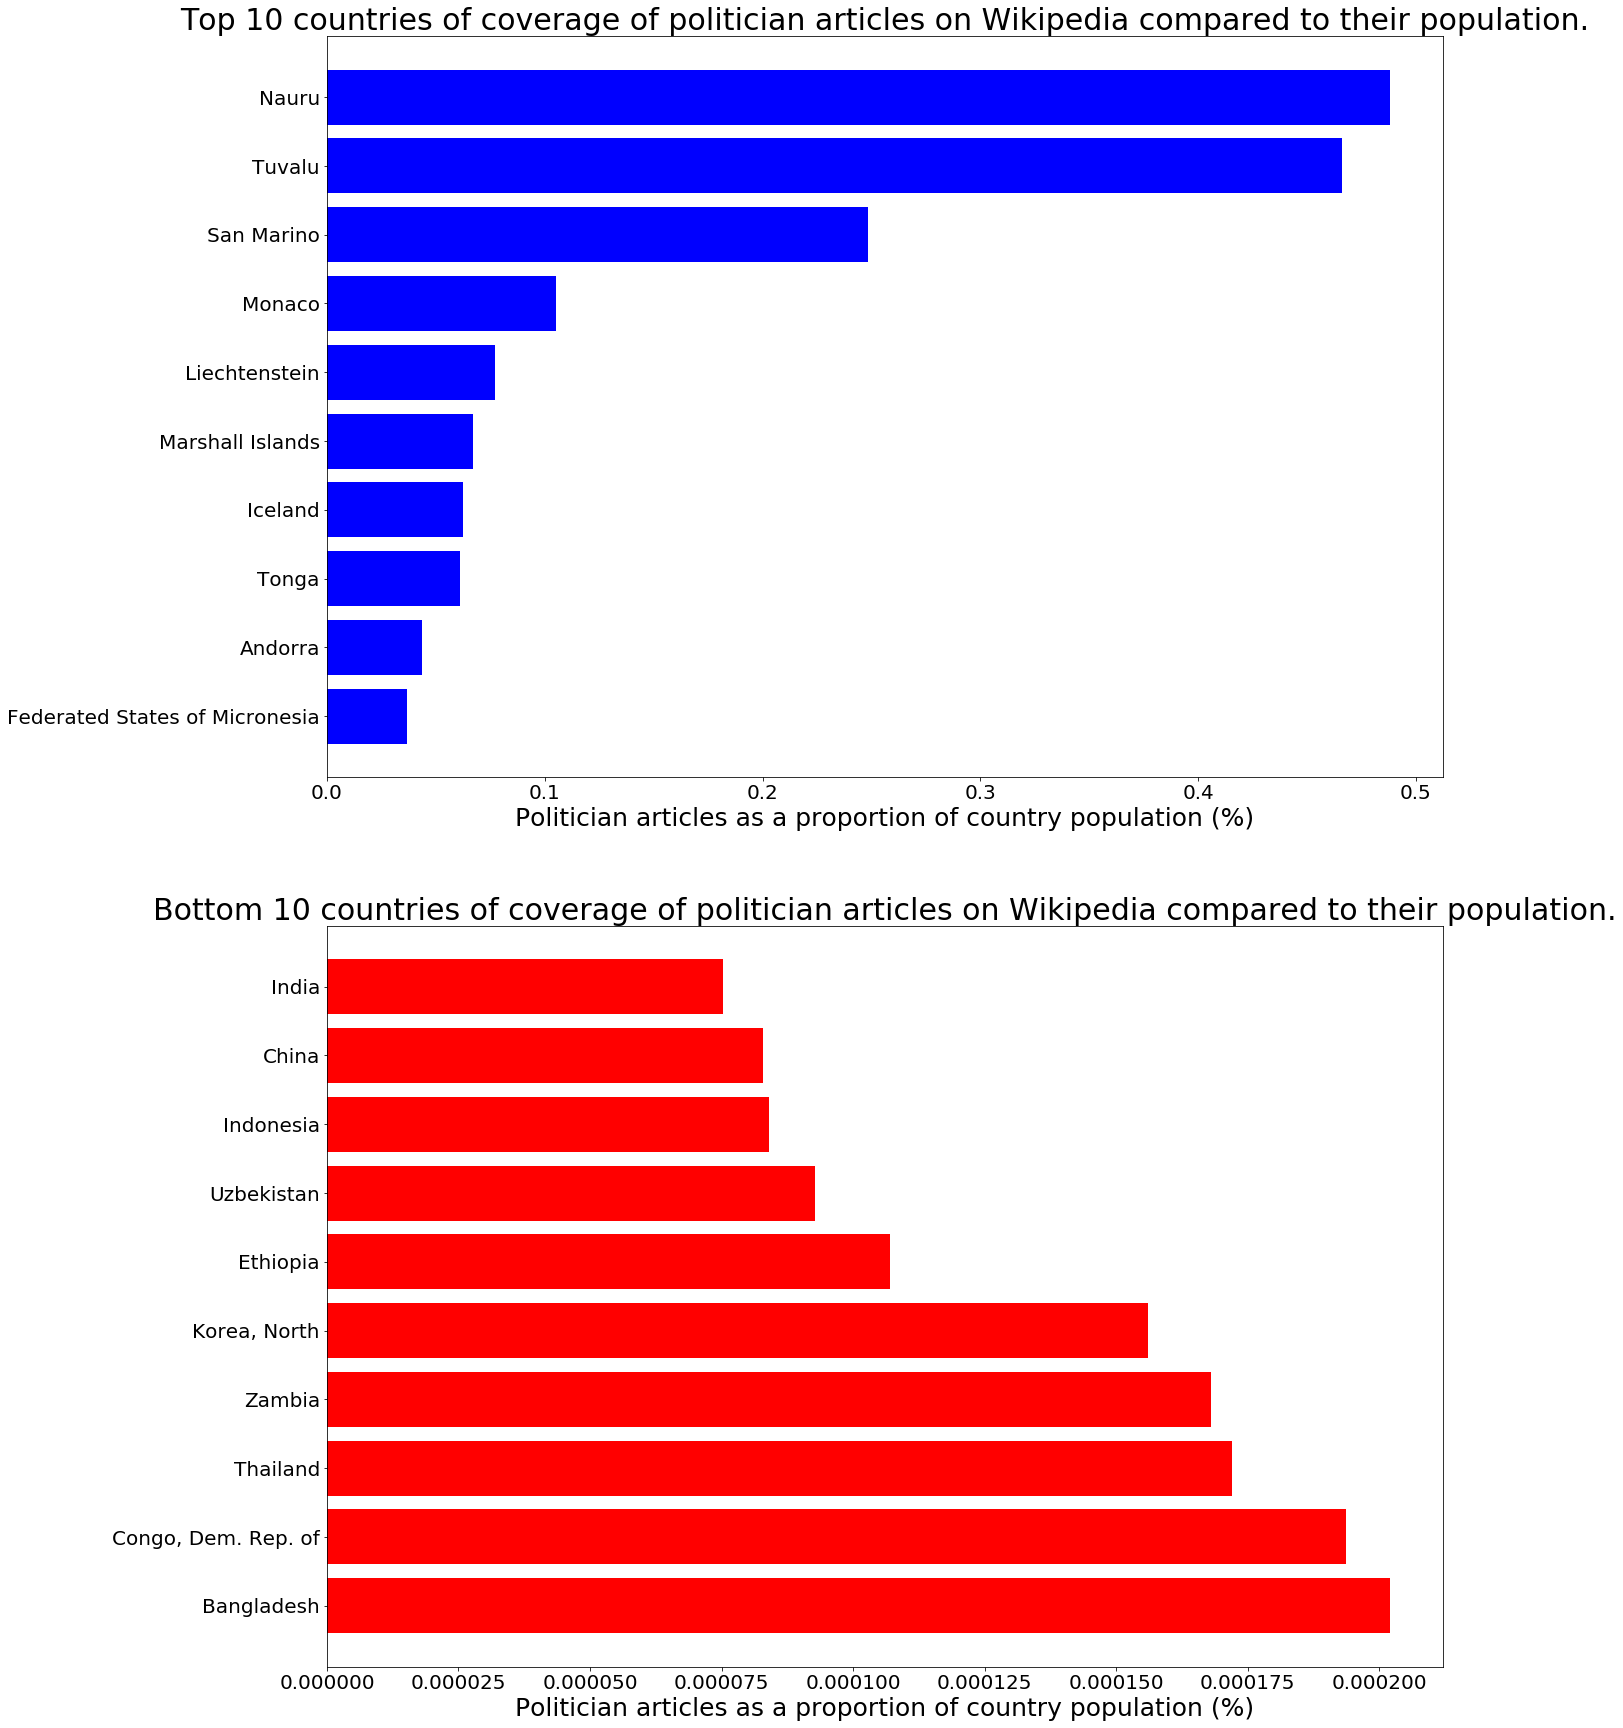

In [20]:
plt.rcParams.update({'font.size': 25})
fig = plt.figure(figsize=(20,30))
ax1=fig.add_subplot(2,1,1)
ax1.barh(y1, x1, align='center', color='b')
ax1.set_yticks(y1)
ax1.set_yticklabels(y1_name)
ax1.invert_yaxis()  
# vals = ax1.get_xticks()
# ax1.set_xticklabels(['{:}%'.format(x) for x in vals])
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel('Politician articles as a proportion of country population (%)', fontsize=25)
ax1.set_title('Top 10 countries of coverage of politician articles on Wikipedia compared to their population.')

ax2=fig.add_subplot(2,1,2)
ax2.barh(y2, x2, align='center', color='r')
ax2.set_yticks(y2)
ax2.set_yticklabels(y2_name)
# vals = ax2.get_xticks()
# ax2.set_xticklabels(['{:}%'.format(x) for x in vals])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel('Politician articles as a proportion of country population (%)', fontsize=25)
ax2.set_title('Bottom 10 countries of coverage of politician articles on Wikipedia compared to their population.')

plt.savefig('politian_article_coverage.png', bbox_inches="tight")

In [10]:
b = results.sort_values(by='percentage_of_high_quality', ascending=False)
b.reset_index(drop=True, inplace=True)
y1_name = b['country'][:10]
y1 = np.arange(len(y1_name)) 
x1 = b['percentage_of_high_quality'][:10]

y2_name = b['country'][-10:]
y2 = np.arange(len(y2_name)) 
x2 = b['percentage_of_high_quality'][-10:]

#### 3. Top 10 countries in terms of proportion of high quality articles about politicians.

In [11]:
b[['country', 'percentage_of_high_quality']][:10]

,country,percentage_of_high_quality
0,"Korea, North",23.076923
1,Romania,12.931034
2,Saudi Arabia,12.605042
3,Central African Republic,11.764706
4,Qatar,9.803922
5,Guinea-Bissau,9.523810
6,Vietnam,9.424084
7,Bhutan,9.090909
8,Ireland,8.136483
9,United States,7.832423


#### 4. Bottom 10 countries in terms of proportion of high quality articles about politicians.

##### Note that the following countries are all of 0 percentage of high quality articles

In [18]:
b.loc[b['percentage_of_high_quality'] == 0.0, ['country', 'percentage_of_high_quality']]

,country,percentage_of_high_quality
148,Bahrain,0.0
149,Dominica,0.0
150,Comoros,0.0
151,Federated States of Micronesia,0.0
152,Cape Verde,0.0
153,Guadeloupe,0.0
154,Bahamas,0.0
155,Lesotho,0.0
156,Swaziland,0.0
157,Belize,0.0


##### A ranomly chosen 10 countries from the above list was used for creating a visualization bar graph

In [23]:
b[['country', 'percentage_of_high_quality']][-10:]

,country,percentage_of_high_quality
177,Tajikistan,0.0
178,Monaco,0.0
179,Tonga,0.0
180,Guyana,0.0
181,Liechtenstein,0.0
182,Sao Tome and Principe,0.0
183,Marshall Islands,0.0
184,Kazakhstan,0.0
185,Macedonia,0.0
186,Seychelles,0.0


##### If I exclude all the countries with 0 percent high quality articles, then the bottom 10 countries list would be:

In [16]:
b.loc[b['percentage_of_high_quality'] != 0.0, ['country', 'percentage_of_high_quality']][-10:]

,country,percentage_of_high_quality
138,Nigeria,0.584795
139,Luxembourg,0.555556
140,Uganda,0.531915
141,Fiji,0.502513
142,Moldova,0.469484
143,Lithuania,0.403226
144,Czech Republic,0.393701
145,Peru,0.282486
146,Tanzania,0.245098
147,Finland,0.174825


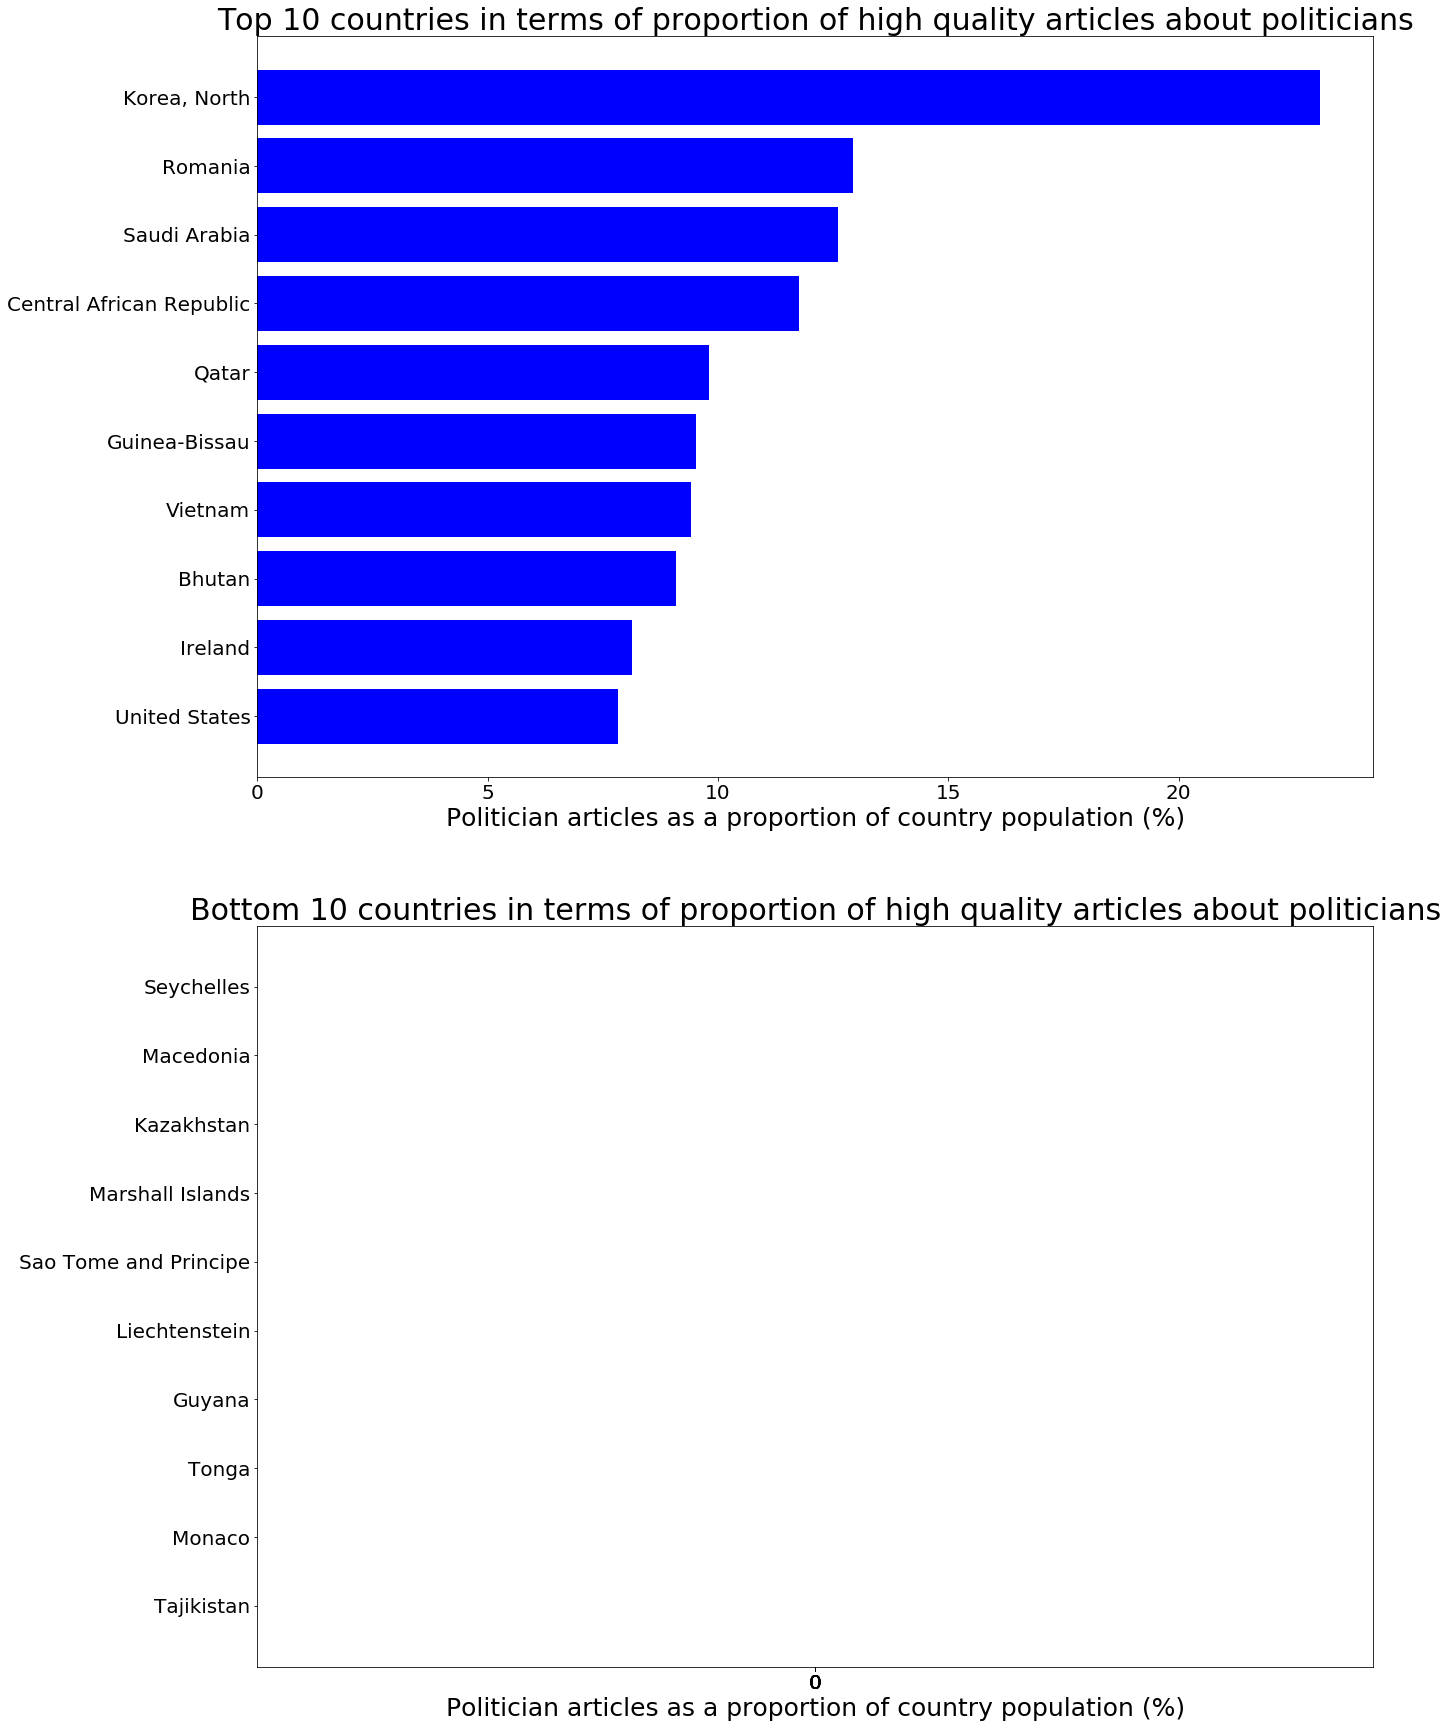

In [39]:
plt.rcParams.update({'font.size': 25})
fig = plt.figure(figsize=(20,30))
ax1=fig.add_subplot(2,1,1)
ax1.barh(y1, x1, align='center', color='b')
ax1.set_yticks(y1)
ax1.set_yticklabels(y1_name)
ax1.invert_yaxis()  
# vals = ax1.get_xticks()
# ax1.set_xticklabels(['{:}%'.format(x) for x in vals])
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel('Politician articles as a proportion of country population (%)', fontsize=25)
ax1.set_title('Top 10 countries in terms of proportion of high quality articles about politicians')

ax2=fig.add_subplot(2,1,2)
ax2.barh(y2, x2, align='center', color='r')
ax2.set_yticks(y2)
ax2.set_yticklabels(y2_name)
ax2.set_xticks([0, 0, 0, 0, 0, 0])
# vals = ax2.get_xticks()
# ax2.set_xticklabels(['{:}%'.format(x) for x in vals])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel('Politician articles as a proportion of country population (%)', fontsize=25)
ax2.set_title('Bottom 10 countries in terms of proportion of high quality articles about politicians')

plt.savefig('high_quality_proportion.png', bbox_inches="tight")